The problem:
Corn rows were planted where each seed planted is assigned a sequence id.  However, those sequence IDs have been partially scrambled.  How can we recover the sequence?

I'm first going to import some tools from numpy, scipy stats, and skilearn, and define some functions for ginning up the kind of data that I'm looking for.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import cluster
%matplotlib inline

def gin_gridded_data(xlim=[0,100],ylim=[0,100],nx=20,ny=5,x_var=.05,y_var=.05):
    
    x = np.linspace(xlim[0],xlim[1],nx)
    y = np.linspace(ylim[0],ylim[1],ny)
    
    x_spacing = x[1]-x[0]
    y_spacing = y[1]-y[0]
    
    # Grid data, ravel back to a vector, and add some variation
    x,y = np.meshgrid(x,y)
    x = x.ravel()
    y = y.ravel()
    
    # Add a little random variation
    x = x + (x_var * x_spacing * np.random.randn(len(x))) - (.5 * x_var * x_spacing)
    y = y + (y_var * y_spacing * np.random.randn(len(y))) - (.5 * y_var * y_spacing)
    
    idx = np.arange(len(x))
    
    return x,y,idx

def swap_ids(x,y,idx,true_idx,swap_len=5):
    pos_a = np.floor(1./4. * len(idx))
    pos_b = 3*pos_a
    temp = idx[pos_a:pos_a + swap_len].copy()
    idx[pos_a:pos_a+swap_len] = idx[pos_b:pos_b+swap_len]
    idx[pos_b:pos_b+swap_len] = temp
    
    M = np.vstack((x,y,idx,true_idx)).T
    M = M[M[:,0].argsort(),]
    x = M[:,0]
    y = M[:,1]
    idx = M[:,2].astype(int)
    true_idx = M[:,3].astype(int)

    return x,y,idx,true_idx

def plot_data(x,y,idx):
    dx,dy = max(x)-min(x),max(y)-min(y)
    plt.plot(x,y,'w.')
    for i in range(len(x)):
        plt.text(x[i],y[i],idx[i],horizontalalignment='center')
    padding = .1
    plt.xlim([min(x)-padding*dx,max(x)+padding*dx])
    plt.ylim([min(y)-padding*dy,max(y)+padding*dy])

That done, I can create a model of the perfect condition:

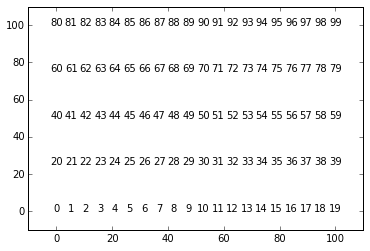

In [2]:
x,y,idx = gin_gridded_data(xlim=[0,100],ylim=[0,100],nx=20,ny=5,
                           x_var=0.00,y_var=.00)                   
plot_data(x,y,idx)

This model has perfectly planted rows.

Next, I scramble some of the data.

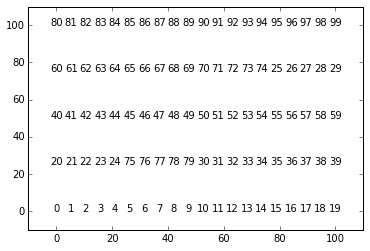

In [3]:
true_idx = idx.copy()
x,y,idx,true_idx = swap_ids(x,y,idx,true_idx,swap_len=5)                         
plot_data(x,y,idx)
    

Now the data is out of sequence.

For a very regular grid, any large value can be used to rescale the space between the rows, and a renumbering based on that product plus the x value will work well.

100.0


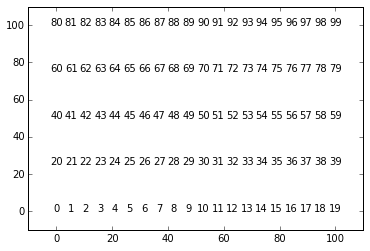

In [4]:
scaling_factor = 5.
score = (scaling_factor * y) + x
new_idx = stats.rankdata(score).astype(int)-1
plot_data(x,y,new_idx)

accuracy = 100.0 * sum(new_idx==true_idx) / len(new_idx)
                     
print(accuracy)

This is a very simple condition.  If the data is not orthogonal, it would need to be rotated via an affine operation for this to work.  One could take the difference of the x and y coordinates separately, and find the median of the arctangent of those values.  As long as the values weren't too scrambled this should work.  Optionally, the user could specify the four corners of the space, and the affine transformation matrix could be calculated that way.

Even with rotation repaired, there will likely be some variability in the data.

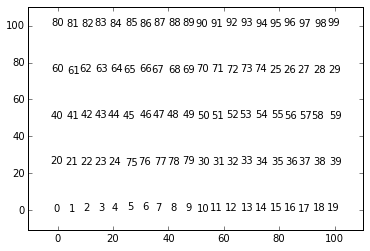

In [5]:
# The ginned data, with random variation and a sequencing error

x,y,idx = gin_gridded_data(xlim=[0,100],ylim=[0,100],nx=20,ny=5,x_var=0.05,y_var=.01)
true_idx = idx.copy()
x,y,idx,true_idx = swap_ids(x,y,idx,true_idx,swap_len=5)                         
plot_data(x,y,idx)




86.0


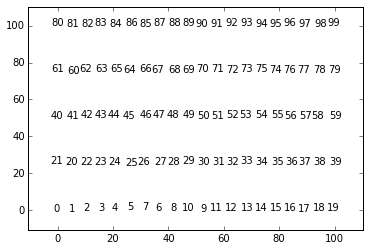

In [6]:
# Attempting a repair with an arbitrary scaling factor

scaling_factor = 10.
score = (scaling_factor * y) + x
new_idx = stats.rankdata(score).astype(int)-1
plot_data(x,y,new_idx)

accuracy = 100.0 * sum(new_idx==true_idx) / len(new_idx)
                     
print(accuracy)

Here, the arbitrary value of 10 for the rescaling was too large yielding less than perfect accuracy.  The 1% y-variability causes  the y-exaggeration strategy to fail.  We can intelligently pick the rescaling factor by guessing the row spacing using k-means clustering.  The idea here is find the y difference between each successive point.  Two kinds of values will show up: small dy values between points, from random variability, and large dy values, from shifts in rows.  A third category will also show up, hidden in the "large" bin, as the sequencing jumps cause even bigger y-shifts.

24.10412775
100.0


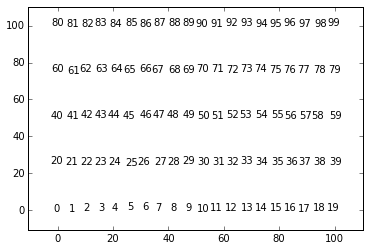

In [9]:
# Distance from one point to the next in the sequence
dy =  y[1:] - y[0:-1]

# K-means fit to two groups: one large and one small
km_y = cluster.KMeans(n_clusters=2,init=np.array([[0,1]]).T)
km_y.fit(np.reshape(abs(dy),(len(dy),1)))

# We can estimate row spacing by looking for the minimum of the larger k-means
# of the dy's
row_spacing = min(abs(dy[km_y.labels_==1]))
print(row_spacing)

# The best fit will be the limits of the x-space divided by the row spacing
scaling_factor = 1.05 * (max(x)-min(x)) / row_spacing

score = (scaling_factor * y) + x
new_idx = stats.rankdata(score).astype(int)-1
plot_data(x,y,new_idx)

accuracy = 100.0 * sum(new_idx==true_idx) / len(new_idx)

print(accuracy)

The calculation of row width helps to more accurately recover the sequence.  However, with significant variability in the y-direction, this strategy will also fail.  


A better strategy would be to find use a clustering algorithm to find the row centers.  K-means would work if we can get a good estimate of the number of rows (e.g.,(https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/). In this way, the y variability for each group could be discarded, using only the group center to drive the y-calculation.